In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.combine import SMOTETomek
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support, roc_curve, roc_auc_score
from matplotlib.pyplot import figure


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
orders = pd.read_excel('orders.xlsx')
orders.dtypes

order_id                              object
customer_id                           object
merchant_id                           object
order_amount                         float64
checkout_started_at           datetime64[ns]
credit_decision_started_at    datetime64[ns]
approved_for_installments               bool
customer_credit_score                  int64
customer_age                           int64
customer_billing_zip                  object
customer_shipping_zip                 object
paid_installment_1                   float64
paid_installment_2                     int64
paid_installment_3                   float64
paid_installment_4                   float64
dtype: object

In [3]:
orders.columns

Index(['order_id', 'customer_id', 'merchant_id', 'order_amount',
       'checkout_started_at', 'credit_decision_started_at',
       'approved_for_installments', 'customer_credit_score', 'customer_age',
       'customer_billing_zip', 'customer_shipping_zip', 'paid_installment_1',
       'paid_installment_2', 'paid_installment_3', 'paid_installment_4'],
      dtype='object')

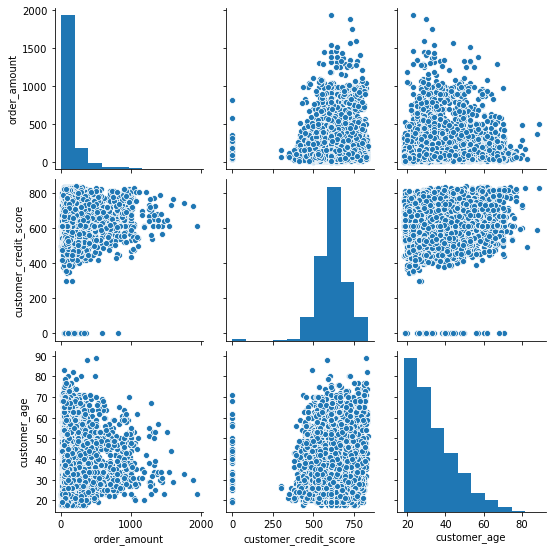

In [4]:
sns.pairplot(orders[['order_amount','customer_credit_score', 'customer_age']])

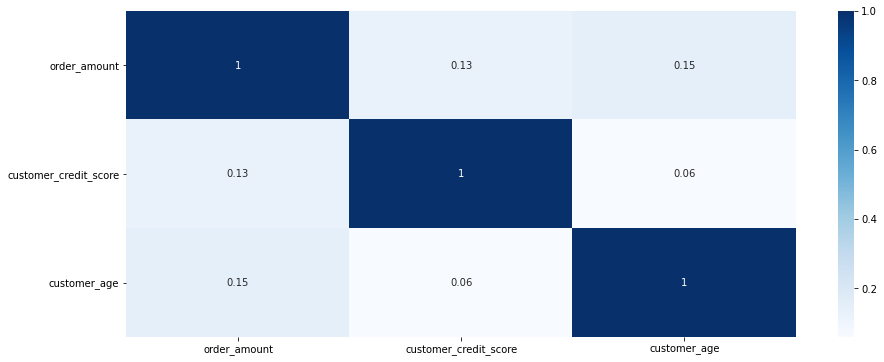

In [5]:
# Correlation Plot

plt.figure(figsize=(15,6))
heatmap = sns.heatmap(orders[['order_amount','customer_credit_score', 'customer_age']].corr(), annot=True, cmap="Blues")

<b> <u>There is almost no multi-collinearity among the variables

In [6]:
orders.describe().T

,count,mean,std,min,25%,50%,75%,max
order_amount,10000.0,146.252272,167.883106,4.95,64.0,90.765,155.00,1936.0
customer_credit_score,10000.0,613.435900,92.555118,1.00,562.0,611.000,664.00,836.0
customer_age,10000.0,33.544300,11.933729,18.00,24.0,30.000,40.25,89.0
paid_installment_1,9998.0,1.000000,0.000000,1.00,1.0,1.000,1.00,1.0
paid_installment_2,10000.0,0.977900,0.147016,0.00,1.0,1.000,1.00,1.0
paid_installment_3,9996.0,0.959684,0.196709,0.00,1.0,1.000,1.00,1.0
paid_installment_4,9423.0,0.940359,0.236834,0.00,1.0,1.000,1.00,1.0


<b><u>Minimum Order value is dollar 4.95 and max is $ 1936<br>
Youngest customers are of 18 years of age eldest is of 89 years of age <br>
Minimum credit score is 1 which must be incorrect, we should treat those records as outlier

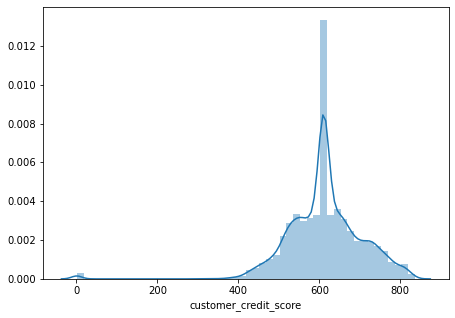

In [7]:
#Z score treatment for outliers
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.distplot(orders['customer_credit_score'])
#plt.subplot(1,2,2)
#sns.distplot(df['placement_exam_marks'])
plt.show()

In [8]:
null_columns = orders.columns[orders.isnull().any()]
orders[null_columns].isnull().sum()

# replacing the Zip values with most frequent repeated Item.

orders['customer_billing_zip'].fillna(orders['customer_billing_zip'].mode()[0], inplace = True)
orders['customer_shipping_zip'].fillna(orders['customer_shipping_zip'].mode()[0], inplace = True)
orders = orders.dropna()

### <b> Logic behind Target Variable <br><br></b>
    
Since our aim is to identify transactions which can be defaulted in future Payments<br><br>
If a Customer has made all payments (all 1's) , Default status will be 0<br>
If a Customer fas missed even a single payment, Default status will be 1

In [9]:
orders['Total_Installment_paid'] = orders['paid_installment_1'] + orders['paid_installment_2'] +orders['paid_installment_3'] + orders['paid_installment_4']

orders['Default_status']  = np.where(orders['Total_Installment_paid'] == 4, 0, 1)
pd.crosstab(orders['Default_status'],orders['Total_Installment_paid'] )

Total_Installment_paid,1.0,2.0,3.0,4.0
Default_status,,,,
0,0,0,0,8752
1,140,203,322,0


In [10]:
orders['Default_status'].value_counts()

0    8752
1     665
Name: Default_status, dtype: int64

<b><u>- Out of Total of 8,752 Total payments 665 are defaulted( 7.6 %).

In [11]:
bins = [0, 300, 350, 400, 450,500,550,600,650,700,750,800,850,900]
names = ['0- 300', '300 - 350', '350 - 400', '400 - 450', '450 - 500','500 - 550','550 - 600','600 - 650','650 - 700','700 - 750','750 - 800','800 - 850','850 - 900']

orders['customer_credit_score_group'] = pd.cut(orders['customer_credit_score'], bins, labels=names)
orders.groupby('customer_credit_score_group').mean()

,order_amount,approved_for_installments,customer_credit_score,customer_age,paid_installment_1,paid_installment_2,paid_installment_3,paid_installment_4,Total_Installment_paid,Default_status
customer_credit_score_group,,,,,,,,,,
0- 300,168.477200,1.0,12.960000,38.740000,1.0,1.000000,1.000000,0.980000,3.980000,0.020000
300 - 350,84.760000,1.0,343.000000,21.000000,1.0,1.000000,1.000000,1.000000,4.000000,0.000000
350 - 400,88.824231,1.0,383.538462,29.000000,1.0,0.961538,0.923077,0.846154,3.730769,0.192308
400 - 450,123.637586,1.0,432.068966,32.224138,1.0,0.850575,0.816092,0.741379,3.408046,0.304598
450 - 500,116.915000,1.0,478.004184,34.447699,1.0,0.943515,0.876569,0.832636,3.652720,0.188285
500 - 550,117.773874,1.0,528.071146,34.000000,1.0,0.963636,0.928063,0.893281,3.784980,0.128854
550 - 600,132.425070,1.0,575.603069,35.294863,1.0,0.968646,0.955971,0.938626,3.863242,0.078719
600 - 650,138.712556,1.0,618.433365,30.793039,1.0,0.983380,0.967074,0.948887,3.899341,0.058953
650 - 700,157.931029,1.0,672.891213,33.894561,1.0,0.998326,0.989121,0.981590,3.969038,0.022594


<b> <u> Customers with the Credit score between 350 - 650 Defaulted most of the payments.<br>
  Customers with Credit score more than 700 are among the least default group.  

Text(0, 0.5, '# of Default payments')

<Figure size 10000x4500 with 0 Axes>

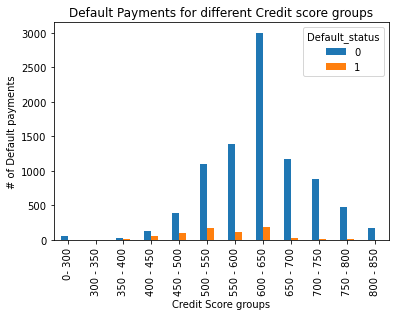

In [12]:
figure(figsize=(20, 9), dpi=500)
pd.crosstab(orders.customer_credit_score_group,orders.Default_status).plot(kind='bar')
plt.title('Default Payments for different Credit score groups')
plt.xlabel('Credit Score groups')
plt.ylabel('# of Default payments')

In [13]:
bins = [10, 30, 40, 50, 60,70,80,90]
names = ['18 - 30', '30 - 40', '40 - 50', '50 - 60', '60 - 70','70 - 80','80 - 90']

orders['customer_age_groups'] = pd.cut(orders['customer_age'], bins, labels=names)
orders.groupby('customer_age_groups').mean()

,order_amount,approved_for_installments,customer_credit_score,customer_age,paid_installment_1,paid_installment_2,paid_installment_3,paid_installment_4,Total_Installment_paid,Default_status
customer_age_groups,,,,,,,,,,
18 - 30,122.749719,True,612.040000,24.224974,1.0,0.975661,0.953651,0.931429,3.860741,0.080635
30 - 40,161.028241,True,606.779065,35.075075,1.0,0.976834,0.958387,0.942514,3.877735,0.068211
40 - 50,169.634375,True,610.678899,45.191955,1.0,0.985180,0.973888,0.954128,3.913197,0.054340
50 - 60,195.608182,True,627.478114,54.897306,1.0,0.978114,0.974747,0.956229,3.909091,0.055556
60 - 70,178.543833,True,653.505226,64.703833,1.0,0.979094,0.968641,0.954704,3.902439,0.052265
70 - 80,119.011864,True,693.101695,73.677966,1.0,1.000000,1.000000,1.000000,4.000000,0.000000
80 - 90,269.360000,True,683.500000,85.500000,1.0,1.000000,1.000000,1.000000,4.000000,0.000000


Text(0, 0.5, '# of Default payments')

<Figure size 10000x4500 with 0 Axes>

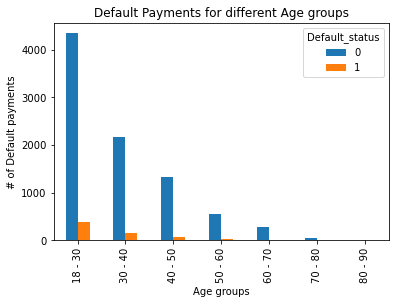

In [14]:
figure(figsize=(20, 9), dpi=500)
pd.crosstab(orders.customer_age_groups,orders.Default_status).plot(kind='bar')
plt.title('Default Payments for different Age groups')
plt.xlabel('Age groups')
plt.ylabel('# of Default payments')

<b> <u> Younger age group customers are less financially responsible and more likely to default compared to elder age group customers.

In [15]:
bins = [0, 100, 300, 600,900,1200,1500,1800,2000]
names = ['0 - 100 $', '100 - 300 $', '300 - 600 $', '600 - 900 $', '900 - 1200 $','1200 - 1500 $','1500 - 1800 $','1800 - 2000 $']

orders['order_amount_groups'] = pd.cut(orders['order_amount'], bins, labels=names)
orders.groupby('order_amount_groups').mean()


,order_amount,approved_for_installments,customer_credit_score,customer_age,paid_installment_1,paid_installment_2,paid_installment_3,paid_installment_4,Total_Installment_paid,Default_status
order_amount_groups,,,,,,,,,,
0 - 100 $,64.083576,True,605.096069,31.792330,1.0,0.978715,0.959923,0.939214,3.877852,0.071908
100 - 300 $,161.694451,True,617.706505,35.036006,1.0,0.976097,0.957035,0.940696,3.873828,0.070499
300 - 600 $,408.708698,True,639.950161,38.273312,1.0,0.979100,0.967846,0.940514,3.887460,0.065916
600 - 900 $,759.382289,True,649.614458,38.927711,1.0,0.981928,0.987952,0.975904,3.945783,0.036145
900 - 1200 $,999.320526,True,660.855263,40.000000,1.0,0.986842,0.960526,0.960526,3.907895,0.052632
1200 - 1500 $,1332.011154,True,672.846154,37.807692,1.0,0.923077,0.961538,0.807692,3.692308,0.230769
1500 - 1800 $,1597.342000,True,698.600000,38.600000,1.0,1.000000,1.000000,1.000000,4.000000,0.000000
1800 - 2000 $,1908.000000,True,667.500000,26.500000,1.0,1.000000,1.000000,1.000000,4.000000,0.000000


Text(0, 0.5, '# of Default payments')

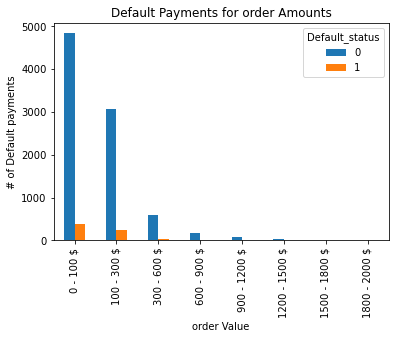

In [16]:
pd.crosstab(orders.order_amount_groups,orders.Default_status).plot(kind='bar')
plt.title('Default Payments for order Amounts')
plt.xlabel('order Value')
plt.ylabel('# of Default payments')

<b> <u>The Lower value orders ( 4 - $600) are more likely to default campared to higher Value orders. 